In [420]:
import numpy as np
import pandas as pd
from urllib2 import Request, urlopen
import json
import sys
from pandas.io.json import json_normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.linear_model import LogisticRegressionCV as LogRegCV
from sklearn import svm
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
%matplotlib inline

Import the CSV.

In [421]:
cleaned_data = pd.read_csv("cleaned_data.csv")
cleaned_data.head(n=3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


Sort to reviews where the denominator is over 15.

In [422]:
rand_1400 = cleaned_data[cleaned_data["HelpfulnessDenominator"] > 15]
rand_1400.shape

(7786, 10)

Use 1400 reviews, because that's what we did on our hw hat one time.

In [423]:
# rand_1400 = cleaned_data.sample(frac=.18)
# rand_1400.shape

In [424]:
'The original set has {0} entries, while our testing set only has {1}.'.format(cleaned_data.shape[0], rand_1400.shape[0])

'The original set has 395131 entries, while our testing set only has 7786.'

Get some basic data from the set.

Range of Review Lengths: 6 words - 2233 words
Mean of Review Lengths: 158.85550989


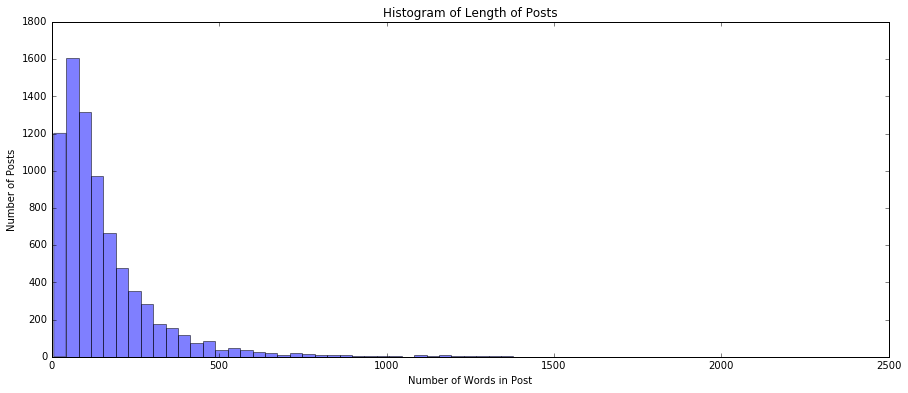

In [425]:
# Splits each review by spaces.
lengths = rand_1400['Text'].apply(lambda x: len(x.split(' ')))

print 'Range of Review Lengths: {0} words - {1} words'.format(np.min(lengths), np.max(lengths))
print 'Mean of Review Lengths: {}'.format(np.mean(lengths))

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Histogram of the word counts in each post
ax.hist(lengths, color='blue', bins=60, alpha=0.5)

ax.set_xlabel('Number of Words in Post')
ax.set_ylabel('Number of Posts')
ax.set_title('Histogram of Length of Posts')

plt.show()

Create a vectorizer. Get the names of all the words. Get the frequency of the words. Zip that shit together and return the top 20 words, using the frequency part of the tuple.

In [426]:
# Create a text vectorizer (turns text into array of numbers)
vectorizer = CountVectorizer(stop_words='english', min_df=1, binary=True)

# Get all the text from data
corpus = rand_1400['Text'].values

# Turn each text into an array of word counts
x = vectorizer.fit_transform(corpus)
x = x.toarray()

# Get the names of all the words we're counting
feature_names = vectorizer.get_feature_names()

#Number of top words
n = 20

#Count the number of time each word occurs in the entire dataset
word_freq = x.sum(axis=0)

#Sort the words by their total frequency in the dataset
words = zip(word_freq, feature_names)
top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

Plot the top 20 words.

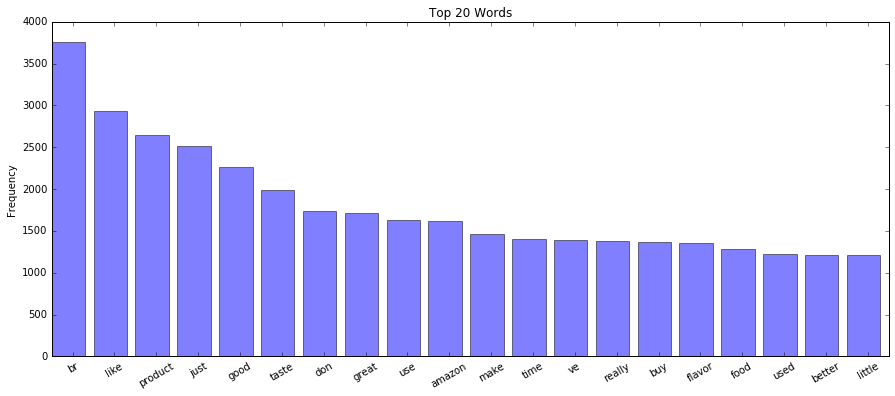

In [427]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Number of bars to use
indices = np.arange(n)
# Where to put the label under each bar
width = 0.5
# Bar plot of the frequencies of the top words
ax.bar(indices, [word[0] for word in top_words], color='blue', alpha=0.5)

ax.set_ylabel('Frequency')
ax.set_title('Top ' + str(n) + ' Words')

# Label the bars with the top words
ax.set_xticks(indices + width)
ax.set_xticklabels([word[1] for word in top_words])

# Turn the labels sideways so they don't overlap
labels = ax.get_xticklabels()
plt.setp(labels, rotation=30, fontsize=10)

plt.show()

Create a y np.array using the helpfulness numerator over the denominator.

In [428]:
# Encode the class labels, things sometimes get funky if you don't do this.
y_numerator = rand_1400['HelpfulnessNumerator'].values
y_denominator = (rand_1400['HelpfulnessDenominator'].values).astype(float)
y = y_numerator / y_denominator

print y_numerator[20:30]
print y_denominator[20:30]
print y[20:30]

[ 5  5 14 32 24 22 18 11 14 17]
[ 16.  27.  17.  36.  27.  25.  26.  24.  21.  17.]
[ 0.3125      0.18518519  0.82352941  0.88888889  0.88888889  0.88
  0.69230769  0.45833333  0.66666667  1.        ]


Check the number of reviews for consistency.

In [429]:
# print 'Number of sub 33% reviews:', len(y[y <= 1./3])
# print 'Number of sub 67% reviews:', len(y[(y > 1./3) & (y < 2./3)])
# print 'Number of sub 100% reviews:', len(y[y >= 2./3])
print 'Number of sub 50% reviews:', len(y[y <= 1./2])
print 'Number of sub 100% reviews:', len(y[y > 1./2])

Number of sub 50% reviews: 1402
Number of sub 100% reviews: 6384


Convert to a 1 vs 2 system, where reviews are given a 2 if over half of users found them helpful and a 1 otherwise. Check the number of reviews for consistency.

In [430]:
y[y > 1./2] = 2
y[y <= 1./2] = 1

In [431]:
# print 'Number of sub 34% reviews:', len(y[y == 1])
# print 'Number of sub 67% reviews:', len(y[y == 2])
# print 'Number of sub 100% reviews:', len(y[y == 3])
print 'Number of sub 50% reviews:', len(y[y == 1])
print 'Number of sub 100% reviews:', len(y[y == 2])

Number of sub 50% reviews: 1402
Number of sub 100% reviews: 6384


Plot the top 20 words

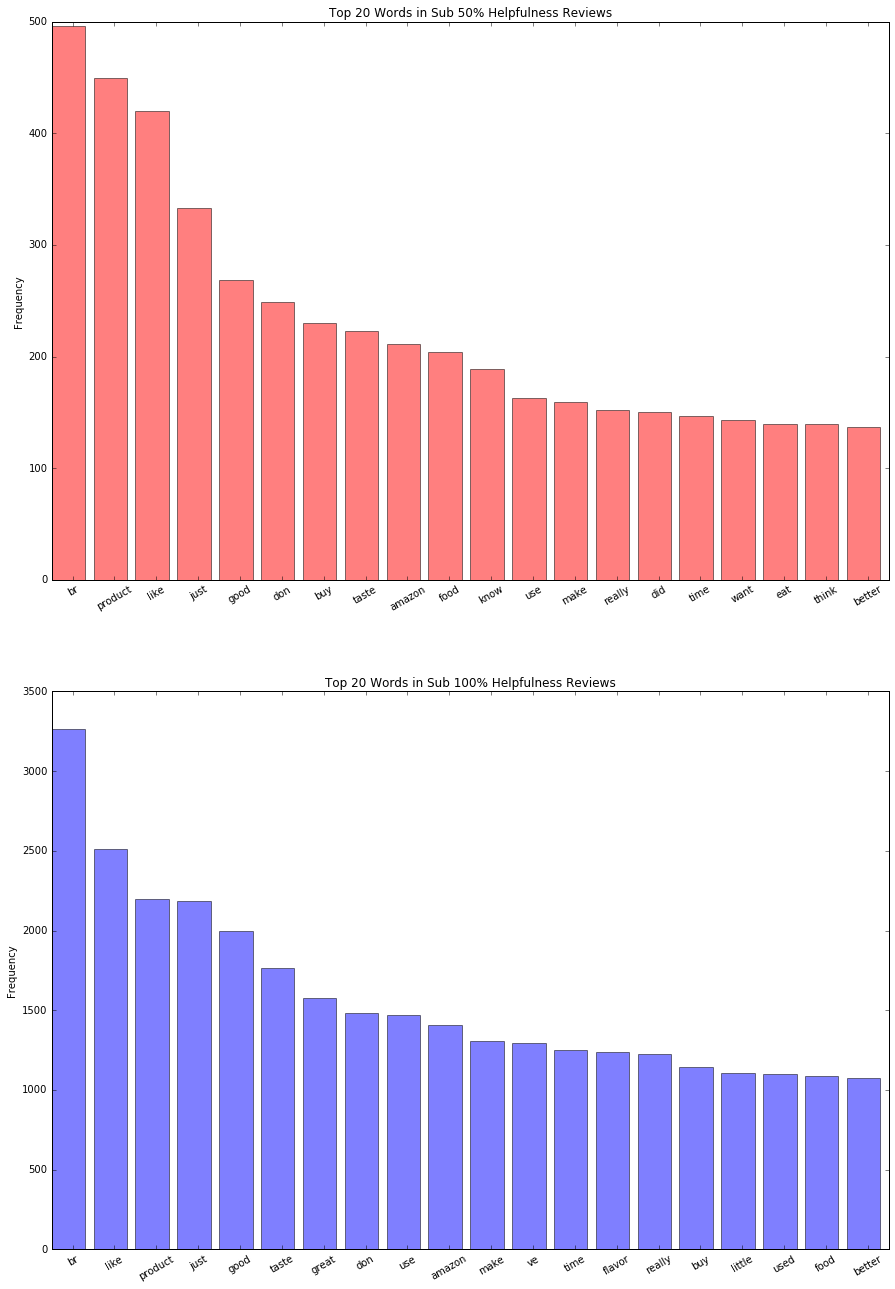

In [432]:
colors = ["red", "blue"]
percents = ["Sub 50%", "Sub 100%"]
fig, ax = plt.subplots(2, 1, figsize=(15, 22))

for i in range(2):
    #Number of bars to use
    indices = np.arange(n)
    #Where to put the label under each bar
    width = 0.5

    #Count the number of time each word occurs
    word_freq = x[y == i+1].sum(axis=0)

    # Sort the words by their total frequency in the dataset
    words = zip(word_freq, feature_names)
    top_words = (sorted(words, key=lambda t: t[0], reverse=True))[:n]

    #B ar plot of the frequencies of the top words
    ax[i].bar(indices, [word[0] for word in top_words], color=colors[i], alpha=0.5)

    ax[i].set_ylabel('Frequency')
    ax[i].set_title('Top ' + str(n) + ' Words in ' + percents[i] + ' Helpfulness Reviews')

    # Label the bars with the top words
    ax[i].set_xticks(indices + width)
    ax[i].set_xticklabels([word[1] for word in top_words])

    # Turn the labels sideways so they don't overlap
    labels = ax[i].get_xticklabels()
    plt.setp(labels, rotation=30, fontsize=10)

plt.show()

Split into a testing and a training set. 2/3 vs. 1/3 respectively. Then run a logistic model on that

In [433]:
# Train/test split
n_samples = len(x)
train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

x_train = x[train_indices]
y_train = y[train_indices]
print "Reviews in Training Set: {0}".format(x_train.shape[0])
x_test = x[~train_indices]
y_test = y[~train_indices]

#Generate array of L2 regularization parameters
regularization = 10.**np.arange(-10, 5)

#Fit logistic model with cross validation to select the optimal regularization parameter
logistic = LogRegCV(cv=5, penalty='l2', Cs=regularization, solver='liblinear', n_jobs=4)
logistic.fit(x_train, y_train)

#Print results
print 'Accuracy on overall test set:', logistic.score(x_test, y_test)
print 'Accuracy on Sub 50% set:', logistic.score(x_test[y_test == 1], y_test[y_test == 1])
print 'Accuracy on Sub 100% set:', logistic.score(x_test[y_test == 2], y_test[y_test == 2])

Reviews in Training Set: 5129
Accuracy on overall test set: 0.825743319533
Accuracy on Sub 50% set: 0.165271966527
Accuracy on Sub 100% set: 0.970628728775


In [434]:
# This function computes the accuracy of logistic regression given cut-offs, min_df, max_df

In [435]:
def vectorize_classify(min_df, max_df, trials, x, y):
    #Create a text vectorizer, removing words with frequency less than min_df or
    #greater than max_df
    vectorizer = CountVectorizer(stop_words='english', min_df=min_df, max_df=max_df)
    #Transform our text into arrays of numbers
    corpus = rand_1400['Text'].values
    x = vectorizer.fit_transform(corpus)
    x = x.toarray()
    
    #Record overall accuracy rate, accuracy on class 1 and class 2
    overall_acc = []
    class_2_acc = []
    class_1_acc = []
    
    
    n_samples = len(x)
    
    #Perform logistic regression on a handful of train/test splits
    for i in range(trials):
        #Print progress
        sys.stdout.write("\r{0}% completed".format((float(i + 1)/trials)*100))
        sys.stdout.flush()
        
        # Train/test split
        train_indices = np.random.uniform(size=n_samples) > 1. / 3.  #Select two thirds for train

        x_train = x[train_indices]
        y_train = y[train_indices]

        x_test = x[~train_indices]
        y_test = y[~train_indices]

        #Generate array of L2 regularization parameters
        regularization = 10. ** np.arange(-10, 5)

        #Fit logistic model
        logistic = LogRegCV(cv=5, 
                            penalty='l2', 
                            Cs=regularization, 
                            solver='liblinear', 
                            n_jobs=4)
        logistic.fit(x_train, y_train)
        
        overall_acc.append(logistic.score(x_test, y_test))
        class_1_acc.append(logistic.score(x_test[y_test == 1], y_test[y_test == 1]))
        class_2_acc.append(logistic.score(x_test[y_test == 2], y_test[y_test == 2]))

    return (np.mean(overall_acc), 
            np.mean(class_1_acc),
            np.mean(class_2_acc))

Test out the function

In [437]:
# Preforms even worse, no reasonable cut off helps, because the helpful words are not centralized among one ocation
min_df = 1100
max_df = 1250
trials = 5
overall, class_1, class_2 = vectorize_classify(min_df, max_df, trials, x, y)
print '\nMin frequency, max frequency:', min_df, ',', max_df
print 'Accuracy on overall test set:', overall
print 'Accuracy on class 1 in test set:', class_1
print 'Accuracy on class 2 in test set:', class_2


100.0% completed
Min frequency, max frequency: 1100 , 1250
Accuracy on overall test set: 0.815489958233
Accuracy on class 1 in test set: 0.0
Accuracy on class 2 in test set: 1.0


In [439]:
# Preforms even worse, no reasonable cut off helps, because the helpful words are not centralized among one ocation
min_df = 1
max_df = 100
trials = 5
overall, class_1, class_2 = vectorize_classify(min_df, max_df, trials, x, y)
print '\nMin frequency, max frequency:', min_df, ',', max_df
print 'Accuracy on overall test set:', overall
print 'Accuracy on class 1 in test set:', class_1
print 'Accuracy on class 2 in test set:', class_2

100.0% completed
Min frequency, max frequency: 1 , 100
Accuracy on overall test set: 0.82397806409
Accuracy on class 1 in test set: 0.0102955241643
Accuracy on class 2 in test set: 0.998336937372


In [440]:
pca = PCA(n_components=800)
pca.fit(x_train)
x_reduced = pca.transform(x)
x_train_red = pca.transform(x_train)
x_test_red = pca.transform(x_test)

logistic.fit(x_train_red, y_train)

y_pred = logistic.predict(x_test_red)
pred_1 = logistic.predict(x_1)
pred_2 = logistic.predict(x_2)

print 'Accuracy for reviews:', np.mean(y_test == y_pred)
print 'Accuracy for sub 50% Helpfulness:', np.mean(y_1 == pred_1)
print 'Accuracy for sub 100% Helpfulness:', np.mean(y_2 == pred_2)

KeyboardInterrupt: 

In [441]:
pca = PCA(n_components=50)
pca.fit(x_train)
x_reduced = pca.transform(x)
x_train_red = pca.transform(x_train)
x_test_red = pca.transform(x_test)

x_1 = x_test_red[y_test==1, :]
x_2 = x_test_red[y_test==2, :]
y_1 = y_test[y_test==1]
y_2 = y_test[y_test==2]


logistic.fit(x_train_red, y_train)

y_pred = logistic.predict(x_reduced)
pred_1 = logistic.predict(x_1)
pred_2 = logistic.predict(x_2)

print 'Accuracy for all reviews:', np.mean(y == y_pred)
print 'Accuracy for sub 50% Helpfulness:', np.mean(y_1 == pred_1)
print 'Accuracy for sub 100% Helpfulness:', np.mean(y_2 == pred_2)

Accuracy for all reviews: 0.81993321346
Accuracy for sub 50% Helpfulness: 0.0
Accuracy for sub 100% Helpfulness: 1.0


In [442]:
pca = PCA(n_components=2)
pca.fit(x_train)
x_reduced = pca.transform(x)
x_train_red = pca.transform(x_train)
x_test_red = pca.transform(x_test)

x_1 = x_test_red[y_test==1, :]
x_2 = x_test_red[y_test==2, :]
y_1 = y_test[y_test==1]
y_2 = y_test[y_test==2]


logistic.fit(x_train_red, y_train)

y_pred = logistic.predict(x_reduced)
pred_1 = logistic.predict(x_1)
pred_2 = logistic.predict(x_2)

print 'Accuracy for all reviews:', np.mean(y == y_pred)
print 'Accuracy for sub 50% Helpfulness:', np.mean(y_1 == pred_1)
print 'Accuracy for sub 100% Helpfulness:', np.mean(y_2 == pred_2)

KeyboardInterrupt: 

C= 0.0001 : 0.820098217186
C= 0.001 : 0.820098217186
C= 0.01 : 0.820098217186
C= 0.1 : 0.821605657786
C= 1 : 0.811816211144
C= 10 : 0.800527816525
C= 100 : 0.79488149606


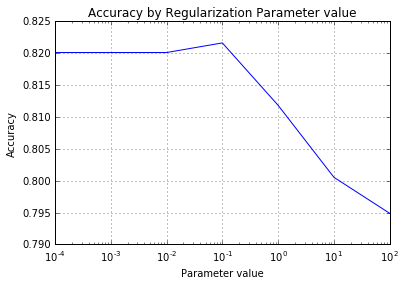

In [443]:
cvals = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
scores = []
for c in cvals: #try cross validating the data with different regularization parameters
    log_model = LogReg(C=c, penalty='l2') #initiate unregularized logistic regression model
    score = cross_val_score(log_model, x_test, y_test, n_jobs=-1).mean() #cross validate
    scores.append(score)
    print "C=",c ,":", score
    
plt.plot(cvals, scores)
plt.xscale('log')
plt.title("Accuracy by Regularization Parameter value")
plt.xlabel("Parameter value")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

In [445]:
log_model = LogReg(C=.1, penalty='l2')
log_model.fit(x_train, y_train)
y_predict = log_model.predict(x_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel() #from sklearn docs
print y_predict.shape
print y_test.shape
print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(y_test, y_predict)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on 2 Class Helpfulness:", np.mean(y_predict[y_test == 2] == y_test[y_test == 2])
print "Accuracy on 1 Class Helpfulness:", np.mean(y_predict[y_test == 1] == y_test[y_test == 1])

(2657,)
(2657,)


WITH CLASS BALANCE CORRECTION
[[  79  399]
 [  64 2115]]

False Positive Rate: 0.834728033473
False Negative Rate: 0.0293712712253
True Positive Rate: 0.841288782816
True Negative Rate: 0.552447552448

Accuracy on 2 Class Helpfulness: 0.970628728775
Accuracy on 1 Class Helpfulness: 0.165271966527


In [446]:
model = svm.SVC(kernel='poly', gamma=2, C=100)
model.fit(x_train, list(y_train))
y_pred_svc = model.predict(x_test)
model.score(x_test, list(y_test))

KeyboardInterrupt: 

In [448]:
svm = svm.LinearSVC(C=0.001, penalty='l2', class_weight='balanced') #initialize logistic regression model
svm.fit(x_train, list(y_train))
y_pred_svm = svm.predict(x_test)
svm.score(x_test, list(y_test))

0.72224313135114793

In [449]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_svm).ravel() #from sklearn docs
print y_pred_svm.shape
print y_test.shape
print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(y_test, y_pred_svm)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on 2 Class Helpfulness:", np.mean(y_pred_svm[y_test == 2] == y_test[y_test == 2])
print "Accuracy on 1 Class Helpfulness:", np.mean(y_pred_svm[y_test == 1] == y_test[y_test == 1])

(2657,)
(2657,)


WITH CLASS BALANCE CORRECTION
[[ 374  104]
 [ 634 1545]]

False Positive Rate: 0.217573221757
False Negative Rate: 0.290959155576
True Positive Rate: 0.93693147362
True Negative Rate: 0.371031746032

Accuracy on 2 Class Helpfulness: 0.709040844424
Accuracy on 1 Class Helpfulness: 0.782426778243


In [ ]:
# print '5-fold cross validation:'
# best_score = 0
# k_folds = KFold(x_train_red.shape[0], n_folds=5, shuffle=True)
# scores = []
# trainers = [None, None]
# for train_indices, validation_indices in k_folds:
#     # Generate training data
#     x_train_cv = x_train_red[train_indices]
#     y_train_cv = y_train[train_indices]
#     # Generate validation data
#     x_validate = x_train_red[validation_indices]
#     y_validate = y_train[validation_indices]

#     # Fit random forest on training data
#     model = svm.SVC(kernel='poly', gamma=2, C=100)
#     model.fit(x_train_cv, list(y_train_cv))
#     if model.score(x_validate, list(y_validate)) > best_score:
#         trainers[0] = x_train_cv
#         trainers[1] = y_train_cv
#     scores += [model.score(x_validate, list(y_validate))]

# average_score = np.mean(scores)
# print "Kernel:", 'poly', "Gamma:", 2, "C:", 100, "Average score:", average_score

# model = svm.SVC(kernel='poly', gamma=2, C=100)
# model.fit(trainers[0], list(trainers[1]))
# print model.score(x_test_red, list(y_test))

In [ ]:
# # Parameters for tuning
# n_trees = np.arange(10, 100, 20)  # Trees and depth are explored on an exponentially growing space,
# depths = np.arange(2, 10)   # since it is assumed that trees and depth will add accuracy in a decaying fashion.

# # To keep track of the best model
# best_score = 0

# # Run grid search for model with 5-fold cross validation
# print '5-fold cross validation:'

# for trees in n_trees:
#     for depth in depths:
        
#         # Cross validation for every experiment
#         k_folds = KFold(x_train_red.shape[0], n_folds=5, shuffle=True)
#         scores = []
#         for train_indices, validation_indices in k_folds:
#             # Generate training data
#             x_train_cv = x_train_red[train_indices]
#             y_train_cv = y_train[train_indices]
#             # Generate validation data
#             x_validate = x_train_red[validation_indices]
#             y_validate = y_train[validation_indices]      
            
#             # Fit random forest on training data
#             model = RandomForestClassifier(n_estimators=trees, max_depth=depth)
#             model.fit(x_train_cv, y_train_cv)
#             # Score on validation data
#             scores += [model.score(x_validate, y_validate)]
        
#         # Record and report accuracy
#         average_score = np.mean(scores)
#         print "Trees:", trees, "Depth:", depth, "Score:", average_score
        
#         # Update our record of the best parameters see so far
#         if average_score > best_score:
#             best_score = average_score
#             best_trees = trees
#             best_depth = depth

# # Fit model on entire train set using chosen number of trees and depth
# model = RandomForestClassifier(n_estimators=best_trees, max_depth=best_depth)
# model.fit(x_train_red, y_train)

# print 'Chosen number of trees, depth:', best_trees, ',', best_depth
# print 'Test accuracy:', model.score(x_test_red, y_test)

In [450]:
new_trainer = rand_1400.sample(frac=.5)
new_tester = rand_1400.drop(new_trainer.index.tolist())

tr_numerator = new_trainer['HelpfulnessNumerator'].values
tr_denominator = (new_trainer['HelpfulnessDenominator'].values).astype(float)
tr_y = tr_numerator / tr_denominator

tr_y[tr_y > 1./2] = 2
tr_y[tr_y <= 1./2] = 1
te_numerator = new_tester['HelpfulnessNumerator'].values
te_denominator = (new_tester['HelpfulnessDenominator'].values).astype(float)
te_y = te_numerator / te_denominator
te_y = np.nan_to_num(te_y)

te_y[te_y > 1./2] = 2
te_y[te_y <= 1./2] = 1

In [451]:
text_clf = Pipeline([('vect', CountVectorizer(stop_words='english', min_df=1, binary=True)), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
text_clf = text_clf.fit(new_trainer['Text'].values, tr_y)
predicted = text_clf.predict(new_tester['Text'].values)
print np.mean(predicted==te_y)

0.816593886463


In [452]:
parameters = {'vect__ngram_range': [(1, 1), (1, 2)], 'tfidf__use_idf': (True, False), 'clf__alpha': (1e-2, 1e-3),}
gs_clf = GridSearchCV(text_clf, parameters, n_jobs=-1)
gs_clf = gs_clf.fit(new_trainer['Text'].values, tr_y)
cv_predicted = gs_clf.predict(new_tester['Text'].values)
print np.mean(cv_predicted==te_y)

0.821474441305


In [453]:
tn, fp, fn, tp = confusion_matrix(te_y, cv_predicted).ravel() #from sklearn docs
print cv_predicted.shape
print te_y.shape
print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(te_y, cv_predicted)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on 2 Class Helpfulness:", np.mean(cv_predicted[te_y == 2] == te_y[te_y == 2])
print "Accuracy on 1 Class Helpfulness:", np.mean(cv_predicted[te_y == 1] == te_y[te_y == 1])

(3893,)
(3893,)


WITH CLASS BALANCE CORRECTION
[[  28  686]
 [   9 3170]]

False Positive Rate: 0.960784313725
False Negative Rate: 0.00283107895565
True Positive Rate: 0.822095435685
True Negative Rate: 0.756756756757

Accuracy on 2 Class Helpfulness: 0.997168921044
Accuracy on 1 Class Helpfulness: 0.0392156862745


In [454]:
frac_helpful = rand_1400['HelpfulnessNumerator'].value_counts()[0] / float(rand_1400['HelpfulnessNumerator'].shape[0])
h_tune = 0.0
weights = {0:1/(1 - frac_helpful + h_tune), 1:1/(frac_helpful - h_tune)}

log_model = LogReg(C=0.01, penalty='l2', class_weight=weights)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel() #from sklearn docs
print y_pred.shape
print y_test.shape
print "\n\nWITH CLASS BALANCE CORRECTION"
print confusion_matrix(y_test, y_pred)
print
print "False Positive Rate:", fp/float(fp+tn)
print "False Negative Rate:", fn/float(fn+tp)
print "True Positive Rate:", tp/float(tp+fp)
print "True Negative Rate:", tn/float(tn+fn)
print
print "Accuracy on 2 Class Helpfulness:", np.mean(y_pred[y_test == 2] == y_test[y_test == 2])
print "Accuracy on 1 Class Helpfulness:", np.mean(y_pred[y_test == 1] == y_test[y_test == 1])

(2657,)
(2657,)


WITH CLASS BALANCE CORRECTION
[[ 126  352]
 [ 128 2051]]

False Positive Rate: 0.73640167364
False Negative Rate: 0.0587425424507
True Positive Rate: 0.853516437786
True Negative Rate: 0.496062992126

Accuracy on 2 Class Helpfulness: 0.941257457549
Accuracy on 1 Class Helpfulness: 0.26359832636
